In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [24]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [25]:
train_df.head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,1617
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,1617
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,1617
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,1617
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,1617
5,Abel_Hernández,1,4,90,Hull City,Leicester City,0.494447,0.650832,True,5,1617
6,Adama_Diomande,1,4,90,Hull City,Leicester City,0.494447,0.650832,True,8,1617
7,Adam_Clayton,1,3,90,Middlesbrough,Stoke City,0.452793,0.718705,True,2,1617
8,Adam_Federici,1,1,0,Bournemouth,Manchester United,0.384921,1.983179,True,0,1617
9,Adam_Forshaw,1,3,69,Middlesbrough,Stoke City,0.452793,0.718705,True,1,1617


In [26]:
train_df.shape

(67936, 11)

In [27]:
# exclude zero minute rows
train_df = train_df[train_df['minutes'] != 0].reset_index()

In [28]:
train_df.shape

(31402, 12)

In [29]:
# find validation cut point - index for 18-19 season second half (gw 19)
valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
#valid_start = train_df[(train_df['season'] == '1819')].index.min()
valid_end = train_df.index.max()

In [30]:
# check data types
train_df.dtypes

index                                    int64
player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
season                                  object
dtype: object

In [123]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes']#, 'relative_market_value_team', 'relative_market_value_opponent_team']

In [124]:
# set dependent variable
dep_var = 'total_points'

In [33]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [34]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [125]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [100]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [141]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [134]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(822, 69)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(27, 10)
    (4): Embedding(27, 10)
    (5): Embedding(3, 3)
    (6): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=112, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [130]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


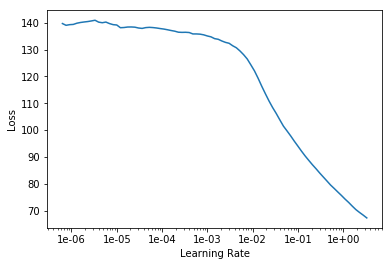

In [131]:
learn.recorder.plot()

In [142]:
# no market value, latest half season validation
learn.fit_one_cycle(4, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.164114,8.411037,2.871964,00:03
1,8.027401,7.991295,2.780493,00:03
2,7.122895,7.703100,2.730206,00:03
3,7.036389,7.476195,2.695957,00:03


In [117]:
# market value, latest half season validation
learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.350640,8.072999,2.797848,00:03
1,7.117079,7.534170,2.705167,00:03
2,6.817882,7.586207,2.713882,00:03


In [97]:
# no market value, new season validation
learn.fit_one_cycle(7, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,4.190550,6.135087,2.440161,00:05
1,3.857543,3.978027,1.933421,00:05
2,3.710502,3.876259,1.927505,00:05
3,3.443164,3.826964,1.915945,00:05
4,3.446122,3.713155,1.877538,00:05
5,3.098882,3.761742,1.897482,00:05
6,2.939469,3.802439,1.905856,00:05


In [105]:
# market value, new season validation
learn.fit_one_cycle(7, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.974407,3.883185,1.914001,00:05
1,3.753403,4.662024,2.126512,00:05
2,3.625479,3.772259,1.889259,00:05
3,3.840882,3.775510,1.897972,00:05
4,3.616885,3.812484,1.901750,00:05
5,3.309392,3.734806,1.886369,00:05
6,2.903124,3.771559,1.897273,00:05


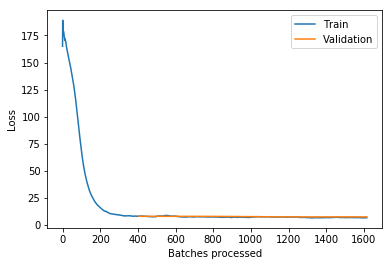

In [51]:
learn.recorder.plot_losses()

In [143]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [144]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,index,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,predicted_points
29349,63363,Aron_Gunnarsson,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,2.557339
29374,63418,Bruno_Ecuele Manga,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,1.551036
29414,63503,David Junior_Hoilett,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,2,1819,3.032903
29468,63618,Harry_Arter,32,3,79,Cardiff City,Chelsea,0.18389,2.540586,True,5,1819,2.084908
29510,63697,Joe_Bennett,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,1.832956
29514,63703,Joe_Ralls,32,3,10,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,0.808422
29529,63736,Josh_Murphy,32,3,89,Cardiff City,Chelsea,0.18389,2.540586,True,2,1819,3.357249
29542,63765,Kenneth_Zohore,32,4,5,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,0.933242
29557,63799,Lee_Peltier,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,1.517984
29607,63922,Nathaniel_Mendez-Laing,32,3,1,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,0.923082


In [145]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,index,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,predicted_points
29266,63182,Mohamed_Salah,31,3,90,Liverpool,Fulham,2.177887,0.405284,False,2,1819,9.454162
28531,61572,Mohamed_Salah,28,3,90,Liverpool,Watford,2.177887,0.412301,True,3,1819,8.892325
28043,60486,Mohamed_Salah,26,3,90,Liverpool,Bournemouth,2.177887,0.418108,True,8,1819,8.826818
29638,63982,Raheem_Sterling,32,3,87,Manchester City,Fulham,2.540586,0.405284,False,3,1819,8.394429
30766,66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,1819,8.331196
26668,57545,Pierre-Emerick_Aubameyang,21,4,90,Arsenal,Fulham,1.435552,0.405284,True,9,1819,8.262475
26107,56366,Mohamed_Salah,19,3,90,Liverpool,Newcastle United,2.177887,0.483921,True,12,1819,8.229300
30466,65818,Mohamed_Salah,35,3,90,Liverpool,Cardiff City,2.177887,0.183890,False,6,1819,8.159647
29289,63223,Sadio_Mané,31,3,90,Liverpool,Fulham,2.177887,0.405284,False,13,1819,7.831429
29091,62786,Mohamed_Salah,30,3,90,Liverpool,Burnley,2.177887,0.449442,True,5,1819,7.757483


In [150]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(2000)['predicted_points'])

4.611256122589111

In [151]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(2000)['total_points'])

4.3345

In [152]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [153]:
remaining_season_df.head(1000)

,gw,team,opponent_team,player,position,price,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,1,Liverpool,Norwich,Alex_Oxlade-Chamberlain,3,6.5,True,2.403290,0.190038,1920,90
1,1,Liverpool,Norwich,Andrew_Robertson,2,7.0,True,2.403290,0.190038,1920,90
2,1,Liverpool,Norwich,Simon_Mignolet,1,4.5,True,2.403290,0.190038,1920,90
3,1,Liverpool,Norwich,Dejan_Lovren,2,5.5,True,2.403290,0.190038,1920,90
4,1,Liverpool,Norwich,Joseph_Gomez,2,5.5,True,2.403290,0.190038,1920,90
5,1,Liverpool,Norwich,Joel_Matip,2,5.5,True,2.403290,0.190038,1920,90
6,1,Liverpool,Norwich,Jordan_Henderson,3,5.5,True,2.403290,0.190038,1920,90
7,1,Liverpool,Norwich,Adam_Lallana,3,6.0,True,2.403290,0.190038,1920,90
8,1,Liverpool,Norwich,James_Milner,3,5.5,True,2.403290,0.190038,1920,90
9,1,Liverpool,Norwich,Roberto_Firmino,4,9.5,True,2.403290,0.190038,1920,90


In [154]:
# create new databunch, including remaining season as test set
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [155]:
# instatiate new tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [156]:
# train as before
learn.fit_one_cycle(4, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,7.859180,9.460079,3.023069,00:03
1,8.141137,8.285160,2.849966,00:03
2,7.451561,7.604105,2.723174,00:03
3,6.990749,7.547910,2.706867,00:03


In [157]:
# get predictions
test_preds=learn.get_preds(DatasetType.Test)
remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [158]:
remaining_season_df.shape

(16074, 12)

In [159]:
# quick look
remaining_season_df.head(20)
#.sort_values(by='predicted_points', ascending=False)

,gw,team,opponent_team,player,position,price,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
0,1,Liverpool,Norwich,Alex_Oxlade-Chamberlain,3,6.5,True,2.40329,0.190038,1920,90,4.732521
1,1,Liverpool,Norwich,Andrew_Robertson,2,7.0,True,2.40329,0.190038,1920,90,5.666708
2,1,Liverpool,Norwich,Simon_Mignolet,1,4.5,True,2.40329,0.190038,1920,90,4.427261
3,1,Liverpool,Norwich,Dejan_Lovren,2,5.5,True,2.40329,0.190038,1920,90,4.366785
4,1,Liverpool,Norwich,Joseph_Gomez,2,5.5,True,2.40329,0.190038,1920,90,4.709034
5,1,Liverpool,Norwich,Joel_Matip,2,5.5,True,2.40329,0.190038,1920,90,4.324038
6,1,Liverpool,Norwich,Jordan_Henderson,3,5.5,True,2.40329,0.190038,1920,90,3.126018
7,1,Liverpool,Norwich,Adam_Lallana,3,6.0,True,2.40329,0.190038,1920,90,5.185101
8,1,Liverpool,Norwich,James_Milner,3,5.5,True,2.40329,0.190038,1920,90,4.139123
9,1,Liverpool,Norwich,Roberto_Firmino,4,9.5,True,2.40329,0.190038,1920,90,5.595664


In [161]:
# write to predictions.csv
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'predicted_points']]
predictions.to_csv('predictions.csv')